# Applied Machine Learning: Credit Card Approval Prediction

*By Daniel Deutsch and José Lucas Barretto*

In [3]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import shap
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost
import matplotlib.patches as mpatches

In [4]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 7),
    'axes.prop_cycle': plt.cycler(color=['#4C72B0', '#C44E52', '#55A868', '#8172B2', '#CCB974', '#64B5CD']),
    'axes.facecolor': '#EAEAF2'
})

# Random state
random_state = 42

## Data Processing

At this staage the goal is to read both datasets and adapt its content for our classification models.

### Processing raw data

#### Credit records

In [5]:
# Reads the dataset
df_credit_record = pd.read_csv("./datasets/credit_record.csv")

# Renames columns
df_credit_record.rename(columns=str.lower, inplace=True)

# Numericalize status
df_credit_record.replace({'status': {'X': 0, 'C': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6}}, inplace=True)

# Calculates the metric
df_credit_record = df_credit_record.groupby('id')['status'].agg(['mean', 'max', 'count']).reset_index()

# Removes clients without a considerate amount of records
df_credit_record = df_credit_record[df_credit_record['count'] > 12]

# Sets the label
df_credit_record['is_good_safe'] = 1*(df_credit_record['mean'] < df_credit_record['mean'].quantile(0.15))
df_credit_record['is_good_risky'] = 1*(df_credit_record['mean'] < df_credit_record['mean'].quantile(0.25))
df_credit_record['is_good_riskier'] = 1*(df_credit_record['mean'] < df_credit_record['mean'].quantile(0.35))

#### Application Records

In [6]:
# Reads the dataset
df_application_record = pd.read_csv("./datasets/application_record.csv")

# Renames columns
df_application_record.rename(columns=str.lower, inplace=True)

# Numericalyze and rename education level
df_application_record.replace({
    'name_education_type': {
        'Higher education': 4,
        'Academic degree': 4,
        'Incomplete higher': 3,
        'Secondary / secondary special': 2,
        'Lower secondary': 1, 
    }
}, inplace=True)
df_application_record.rename(columns={'name_education_type': 'education_level'}, inplace=True)

# Transform days employed into is_unemployed
df_application_record['is_unemployed'] = 1*(df_application_record['days_employed'] > 0)

# Drop uninteresting columns - birthday, days employed
df_application_record.drop(columns=['days_employed', 'days_birth'], inplace=True)

#### Merging data

In [7]:
df = pd.merge(df_credit_record, df_application_record, how='inner', on='id')

### Train-test split

In [8]:
# Define categorical, numerical, and other interesting vars
categorical = [
    'code_gender', 
    'flag_own_car', 
    'flag_own_realty', 
    'name_income_type',
    'name_family_status', 
    'name_housing_type', 
    'flag_mobil', 
    'flag_work_phone',
    'flag_phone', 
    'flag_email',
    'occupation_type'
]

numerical = [
    'cnt_children',
    'amt_income_total',
    'cnt_fam_members'
]

other = [
    'is_unemployed',
    'education_level'
]

# Define X and y datasets
X = df[categorical + numerical + other]
y = df[['is_good_safe', 'is_good_risky', 'is_good_riskier']]

# Split between train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

### Processing features

In [9]:
# Initialize encoder for categorical vars
enc = OneHotEncoder(drop='first', sparse=False)

# Fit transform encoder to train data
X_train_categorical = pd.DataFrame(enc.fit_transform(X_train[categorical]), index=X_train.index, columns=enc.get_feature_names_out())

# Transform encoder to test data
X_test_categorical = pd.DataFrame(enc.transform(X_test[categorical]), index=X_test.index, columns=enc.get_feature_names_out())

In [10]:
# Initialize scaler for numerical vars
scaler = StandardScaler()

# Fit transform scaler to train data
X_train_numerical = pd.DataFrame(scaler.fit_transform(X_train[numerical]), index=X_train.index, columns=numerical)

# Transform scaler to test data
X_test_numerical = pd.DataFrame(scaler.transform(X_test[numerical]), index=X_test.index, columns=numerical)

In [11]:
# Concatenate numerical and categorical vars
X_train_normal = pd.concat((X_train_numerical, X_train_categorical, X_train[other]), axis=1)
X_test_normal = pd.concat((X_test_numerical, X_test_categorical, X_test[other]), axis=1)

### Defining a customer profile

In [12]:
df_customer_profile = pd.DataFrame([{
    'id': 5150488,
    'mean': 0.1,
    'max': 2,
    'count': 20,
    'is_good_safe': 0,
    'is_good_risky':1,
    'is_good_riskier': 1,
    'code_gender': 'M',
    'flag_own_car': 'N',
    'flag_own_realty': 'Y',
    'cnt_children': 0,
    'amt_income_total': 60000,
    'name_income_type': 'Working',
    'education_level': 3,
    'name_family_status': 'Single / not married',
    'name_housing_type': 'Rented apartment',
    'flag_mobil': 1,
    'flag_work_phone': 0,
    'flag_phone': 1,
    'flag_email': 1,
    'occupation_type': 'High skill tech staff',
    'cnt_fam_members': 0,
    'is_unemployed': 0
}])

df_customer_profile_cat = pd.DataFrame(enc.transform(df_customer_profile[categorical]), columns=enc.get_feature_names_out())
df_customer_profile_num = pd.DataFrame(scaler.transform(df_customer_profile[numerical]), columns=numerical)
df_customer_profile = pd.concat((df_customer_profile_num, df_customer_profile_cat, df_customer_profile[other]), axis=1)

# Data Visualization

In [13]:
print(f"The worst client considered as good in the safe category is labeled as {df_credit_record[df_credit_record['is_good_safe'] == 1]['max'].max()}")
print(f"The worst client considered as good in the risky category is labeled as {df_credit_record[df_credit_record['is_good_risky'] == 1]['max'].max()}")
print(f"The worst client considered as good in the riskier category is labeled as {df_credit_record[df_credit_record['is_good_riskier'] == 1]['max'].max()}")

The worst client considered as good in the safe category is labeled as 2
The worst client considered as good in the risky category is labeled as 3
The worst client considered as good in the riskier category is labeled as 6


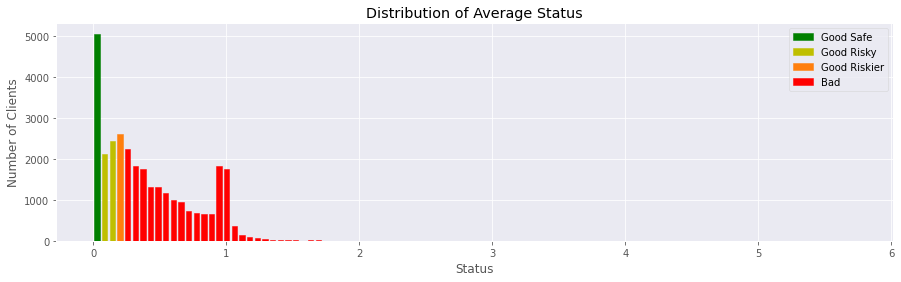

In [14]:
plt.figure(figsize=(15, 4))
ax = df_credit_record['mean'].hist(bins=100, rwidth=0.7)

for rect in ax.patches:
    rect.set_color('r')
    if rect.get_x() < df_credit_record['mean'].quantile(0.15):
        rect.set_color('g')
    elif rect.get_x() < df_credit_record['mean'].quantile(0.25):
        rect.set_color('y')
    elif rect.get_x() < df_credit_record['mean'].quantile(0.35):
        rect.set_color('tab:orange')

good_safe = mpatches.Patch(color='g', label='Good Safe')
good_risky = mpatches.Patch(color='y', label='Good Risky')
good_riskier = mpatches.Patch(color='tab:orange', label='Good Riskier')
bad = mpatches.Patch(color='r', label='Bad')
plt.legend(handles=[good_safe, good_risky, good_riskier, bad])
plt.title("Distribution of Average Status")
plt.ylabel("Number of Clients")
plt.xlabel("Status")
plt.show()

# Modeling, Feature Selection, Explainability

## Safe Risk Profile

### Logistic Regression (Benchmark)

In [15]:
# Builds and trains the model
model = LogisticRegressionCV(cv=3, penalty='l2', scoring='roc_auc', class_weight='balanced', solver='liblinear')
model_fit = model.fit(X_train_normal, y_train[['is_good_safe']])

# Prints the classification report
print(classification_report(y_test['is_good_safe'], model_fit.predict(X_test_normal), zero_division=0))
print(f"ROC AUC: {roc_auc_score(y_test['is_good_safe'], model_fit.predict(X_test_normal))}")

              precision    recall  f1-score   support

           0       0.87      0.52      0.65      6076
           1       0.14      0.48      0.21       950

    accuracy                           0.52      7026
   macro avg       0.50      0.50      0.43      7026
weighted avg       0.77      0.52      0.59      7026

ROC AUC: 0.5022939260593882


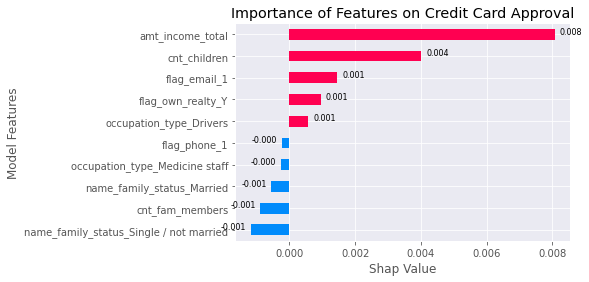

In [16]:
explainer = shap.Explainer(model, X_train_normal)
shap_values = explainer(X_test_normal)

coefs = pd.DataFrame(shap_values.values.mean(axis=0), index=X_train_normal.columns)
coefs.columns = ['shap']
coefs['positive'] = coefs['shap'] > 0
coefs.sort_values('shap', inplace=True)
coefs = pd.concat((coefs.iloc[:5], coefs.iloc[-5:]))

coefs['shap'].plot(kind='barh', color=coefs.positive.map({True: '#FF0051', False: '#008BFB'}))

ax = plt.gca()
for p in ax.patches:
    if p.get_width() > 0:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 6), size=8, textcoords='offset points')
    else:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(-30, 6), size=8, textcoords='offset points')

plt.xlabel("Shap Value")
plt.ylabel("Model Features")
plt.title("Importance of Features on Credit Card Approval")
plt.show()

### XGBoost

In [17]:
# Oversamples underrepresented class
oversample = SMOTE()
X_train_normal_safe, y_train_safe = oversample.fit_resample(X_train_normal, y_train[['is_good_safe']])

# Loads models and defines parameters
model = xgboost.XGBClassifier(
    eval_metric='auc',
    max_depth=20,
    n_estimators=200
    )
model_fit = model.fit(X_train_normal_safe, y_train_safe)

# Prints the classification report
print(classification_report(y_test['is_good_safe'], model_fit.predict(X_test_normal), zero_division=0))
print(f"ROC AUC: {roc_auc_score(y_test['is_good_safe'], model_fit.predict(X_test_normal))}")

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      6076
           1       0.39      0.38      0.38       950

    accuracy                           0.84      7026
   macro avg       0.65      0.64      0.65      7026
weighted avg       0.83      0.84      0.84      7026

ROC AUC: 0.6427495582273657


100%|===================| 6997/7026 [02:44<00:00]        

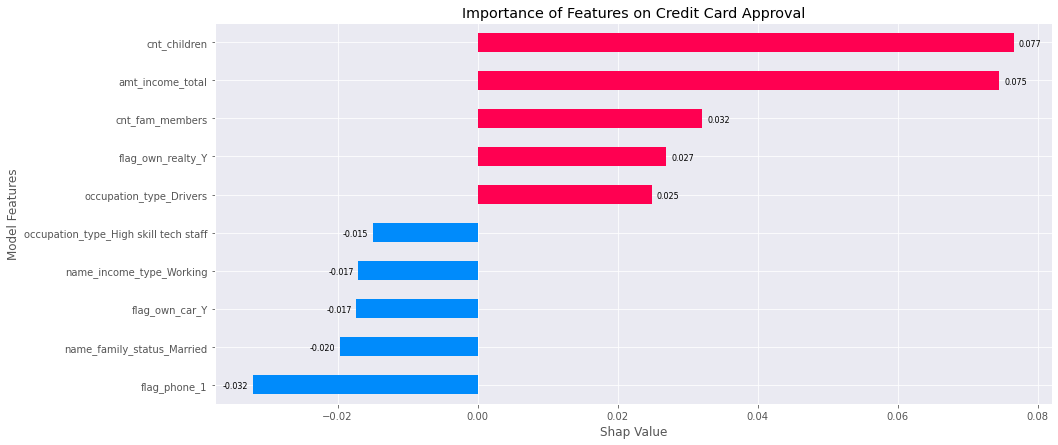

In [63]:
explainer = shap.TreeExplainer(model_fit, X_train_normal)
shap_values = explainer(X_test_normal)

coefs = pd.DataFrame(shap_values.values.mean(axis=0), index=X_train_normal.columns)
coefs.columns = ['shap']
coefs['positive'] = coefs['shap'] > 0
coefs.sort_values('shap', inplace=True)
coefs = pd.concat((coefs.iloc[:5], coefs.iloc[-5:]))

coefs['shap'].plot(kind='barh', color=coefs.positive.map({True: '#FF0051', False: '#008BFB'}))

ax = plt.gca()
for p in ax.patches:
    if p.get_width() > 0:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 6), size=8, textcoords='offset points')
    else:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(-30, 6), size=8, textcoords='offset points')

plt.xlabel("Shap Value")
plt.ylabel("Model Features")
plt.title("Importance of Features on Credit Card Approval")
plt.show()

### Customer Profile

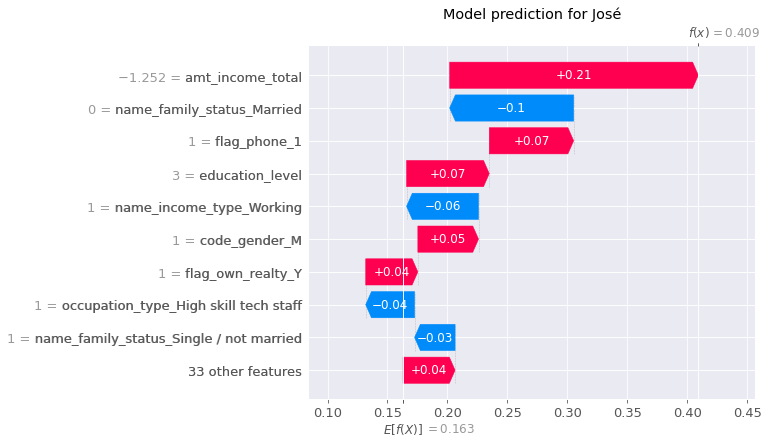

In [154]:
explainer = shap.TreeExplainer(model_fit, X_train_normal, model_output="probability")
shap_values = explainer(df_customer_profile)
plt.title('Model prediction for José')
shap.plots.waterfall(shap_values[0])
plt.show()

## Risky Risk Portfolio

### Logistic Regression (Benchmark)

In [15]:
# Builds and trains the model
model = LogisticRegressionCV(cv=3, penalty='l2', scoring='roc_auc', class_weight='balanced', solver='liblinear')
model_fit = model.fit(X_train_normal, y_train[['is_good_risky']])

# Prints the classification report
print(classification_report(y_test['is_good_risky'], model_fit.predict(X_test_normal), zero_division=0))
print(f"ROC AUC: {roc_auc_score(y_test['is_good_risky'], model_fit.predict(X_test_normal))}")

              precision    recall  f1-score   support

           0       0.78      0.53      0.63      5409
           1       0.24      0.51      0.33      1617

    accuracy                           0.53      7026
   macro avg       0.51      0.52      0.48      7026
weighted avg       0.66      0.53      0.56      7026

ROC AUC: 0.5190680618538951


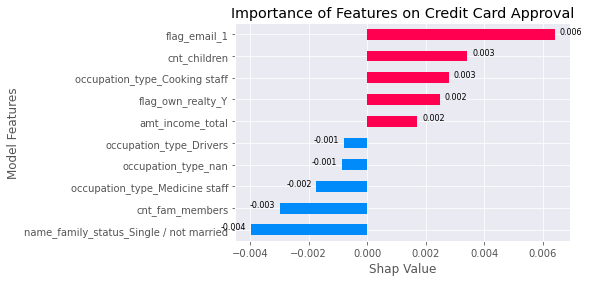

In [16]:
explainer = shap.Explainer(model, X_train_normal)
shap_values = explainer(X_test_normal)

coefs = pd.DataFrame(shap_values.values.mean(axis=0), index=X_train_normal.columns)
coefs.columns = ['shap']
coefs['positive'] = coefs['shap'] > 0
coefs.sort_values('shap', inplace=True)
coefs = pd.concat((coefs.iloc[:5], coefs.iloc[-5:]))

coefs['shap'].plot(kind='barh', color=coefs.positive.map({True: '#FF0051', False: '#008BFB'}))

ax = plt.gca()
for p in ax.patches:
    if p.get_width() > 0:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 6), size=8, textcoords='offset points')
    else:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(-30, 6), size=8, textcoords='offset points')

plt.xlabel("Shap Value")
plt.ylabel("Model Features")
plt.title("Importance of Features on Credit Card Approval")
plt.show()

### XGBoost

In [161]:
# Oversamples underrepresented class
oversample = SMOTE()
X_train_normal_risky, y_train_risky = oversample.fit_resample(X_train_normal, y_train[['is_good_risky']])

# Loads models and defines parameters
model = xgboost.XGBClassifier(
    eval_metric='auc',
    max_depth=20,
    n_estimators=200
    )
model_fit = model.fit(X_train_normal_risky, y_train_risky)

# Prints the classification report
print(classification_report(y_test['is_good_risky'], model_fit.predict(X_test_normal), zero_division=0))
print(f"ROC AUC: {roc_auc_score(y_test['is_good_risky'], model_fit.predict(X_test_normal))}")

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      5409
           1       0.44      0.42      0.43      1617

    accuracy                           0.74      7026
   macro avg       0.63      0.63      0.63      7026
weighted avg       0.74      0.74      0.74      7026

ROC AUC: 0.6304055530345049


100%|===================| 6991/7026 [02:50<00:00]        

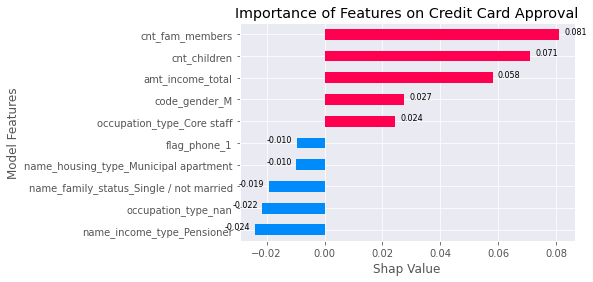

In [ ]:
explainer = shap.TreeExplainer(model_fit, X_train_normal)
shap_values = explainer(X_test_normal)

coefs = pd.DataFrame(shap_values.values.mean(axis=0), index=X_train_normal.columns)
coefs.columns = ['shap']
coefs['positive'] = coefs['shap'] > 0
coefs.sort_values('shap', inplace=True)
coefs = pd.concat((coefs.iloc[:5], coefs.iloc[-5:]))

coefs['shap'].plot(kind='barh', color=coefs.positive.map({True: '#FF0051', False: '#008BFB'}))

ax = plt.gca()
for p in ax.patches:
    if p.get_width() > 0:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 6), size=8, textcoords='offset points')
    else:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(-30, 6), size=8, textcoords='offset points')

plt.xlabel("Shap Value")
plt.ylabel("Model Features")
plt.title("Importance of Features on Credit Card Approval")
plt.show()

### Customer Profile

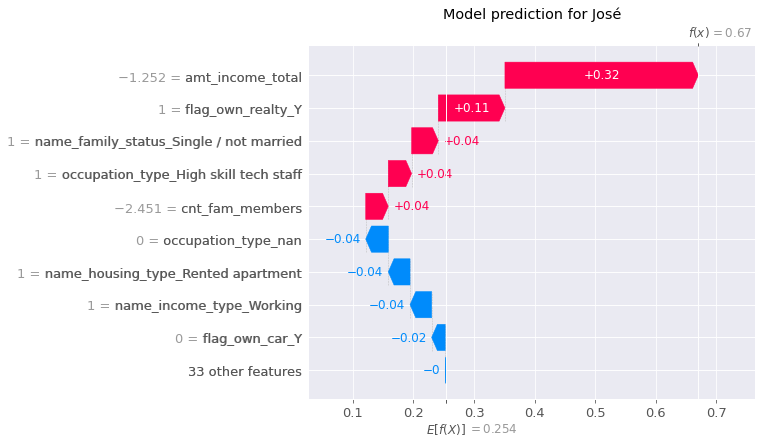

In [162]:
explainer = shap.TreeExplainer(model_fit, X_train_normal, model_output="probability")
shap_values = explainer(df_customer_profile)
plt.title('Model prediction for José')
shap.plots.waterfall(shap_values[0])
plt.show()

## Riskier Risk Portfolio

### Logistic Regression (Benchmark)

In [30]:
# Builds and trains the model
model = LogisticRegressionCV(cv=3, penalty='l2', scoring='roc_auc', class_weight='balanced', solver='liblinear')
model_fit = model.fit(X_train_normal, y_train[['is_good_riskier']])

# Prints the classification report
print(classification_report(y_test['is_good_riskier'], model_fit.predict(X_test_normal), zero_division=0))
print(f"ROC AUC: {roc_auc_score(y_test['is_good_riskier'], model_fit.predict(X_test_normal))}")

              precision    recall  f1-score   support

           0       0.69      0.53      0.60      4714
           1       0.35      0.51      0.42      2312

    accuracy                           0.53      7026
   macro avg       0.52      0.52      0.51      7026
weighted avg       0.58      0.53      0.54      7026

ROC AUC: 0.5235811974344255


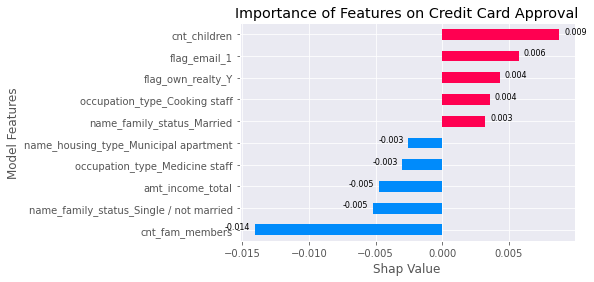

In [31]:
explainer = shap.Explainer(model, X_train_normal)
shap_values = explainer(X_test_normal)

coefs = pd.DataFrame(shap_values.values.mean(axis=0), index=X_train_normal.columns)
coefs.columns = ['shap']
coefs['positive'] = coefs['shap'] > 0
coefs.sort_values('shap', inplace=True)
coefs = pd.concat((coefs.iloc[:5], coefs.iloc[-5:]))

coefs['shap'].plot(kind='barh', color=coefs.positive.map({True: '#FF0051', False: '#008BFB'}))

ax = plt.gca()
for p in ax.patches:
    if p.get_width() > 0:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 6), size=8, textcoords='offset points')
    else:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(-30, 6), size=8, textcoords='offset points')

plt.xlabel("Shap Value")
plt.ylabel("Model Features")
plt.title("Importance of Features on Credit Card Approval")
plt.show()

### XGBoost

In [18]:
# Oversamples underrepresented class
oversample = SMOTE()
X_train_normal_riskier, y_train_riskier = oversample.fit_resample(X_train_normal, y_train[['is_good_riskier']])

# Loads models and defines parameters
model = xgboost.XGBClassifier(
    eval_metric='auc',
    max_depth=20,
    n_estimators=200
    )
model_fit = model.fit(X_train_normal_riskier, y_train_riskier)

# Prints the classification report
print(classification_report(y_test['is_good_riskier'], model_fit.predict(X_test_normal), zero_division=0))
print(f"ROC AUC: {roc_auc_score(y_test['is_good_riskier'], model_fit.predict(X_test_normal))}")

              precision    recall  f1-score   support

           0       0.75      0.76      0.76      4714
           1       0.50      0.49      0.49      2312

    accuracy                           0.67      7026
   macro avg       0.62      0.62      0.62      7026
weighted avg       0.67      0.67      0.67      7026

ROC AUC: 0.6236728775215693


100%|===================| 7017/7026 [03:04<00:00]        

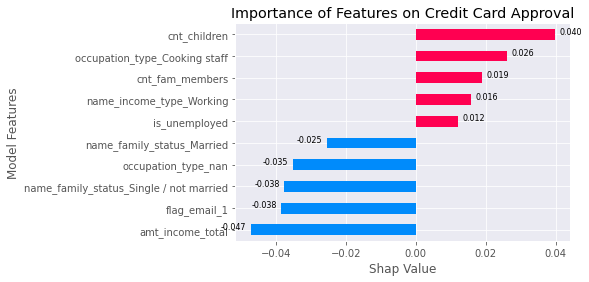

In [19]:
explainer = shap.TreeExplainer(model_fit, X_train_normal)
shap_values = explainer(X_test_normal)

coefs = pd.DataFrame(shap_values.values.mean(axis=0), index=X_train_normal.columns)
coefs.columns = ['shap']
coefs['positive'] = coefs['shap'] > 0
coefs.sort_values('shap', inplace=True)
coefs = pd.concat((coefs.iloc[:5], coefs.iloc[-5:]))

coefs['shap'].plot(kind='barh', color=coefs.positive.map({True: '#FF0051', False: '#008BFB'}))

ax = plt.gca()
for p in ax.patches:
    if p.get_width() > 0:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 6), size=8, textcoords='offset points')
    else:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(-30, 6), size=8, textcoords='offset points')

plt.xlabel("Shap Value")
plt.ylabel("Model Features")
plt.title("Importance of Features on Credit Card Approval")
plt.show()

### Customer Profile

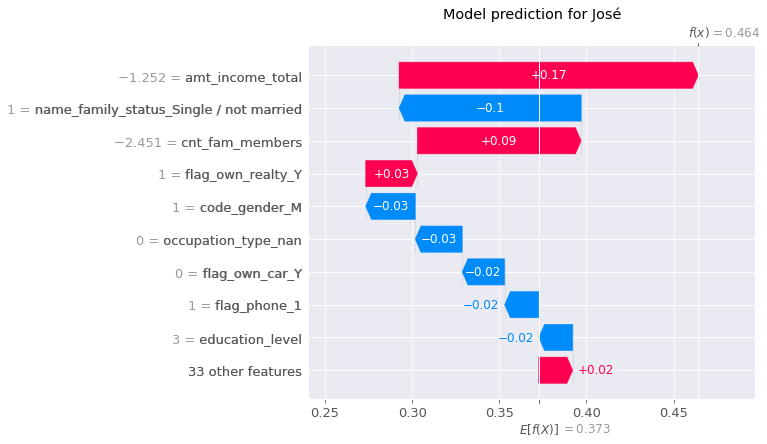

In [21]:
explainer = shap.TreeExplainer(model_fit, X_train_normal, model_output="probability")
shap_values = explainer(df_customer_profile)
plt.title('Model prediction for José')
shap.plots.waterfall(shap_values[0])
plt.show()